# Deep learning programming I-A: Regression
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 08.02.2021
###  Implementation

In the following we consider a simple regression task, implement a neural network and train it based on the mathematical fomrulation above. For this we first need to create a set of input-output pairs, which then needs to be partitioned into a training, validation and test set. We also define some constants to be used for partitioning the data and the hyperparameters for our neural network.

But before we can start, we need to import the necessary packages tensorflow, numpy and matplotlib.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Next we define our constants and set the random seeds of tensorflow and numpy in order to get reproducable results.

In [2]:
N_train_samples = 600
N_validation_samples = 100
N_test_samples = 100
N_samples = N_train_samples + N_validation_samples + N_test_samples
noise_sig = 0.1
N_epochs = 150
batch_size = 8
learning_rate = 0.01

tf.random.set_seed(0)
np.random.seed(0)

We create $600$ training samples, $100$ validation samples to optimize our hyperparameters and $100$ test samples, which are used to check if our model can generalize to unseen data. Furthermore we set the level of noise added to the observations. For training the model we plan to train it for $150$ epochs with a batch size of $8$ and a learning rate of $0.01$. Next we create the actual input-output pairs $\mathbf{x},\mathbf{y}$ for which we want to learn the regression model and plot them. In this simple example we choose scalar inputs as well as output but in general $\mathbf{x}$ and $\mathbf{y}$ can be vectors.

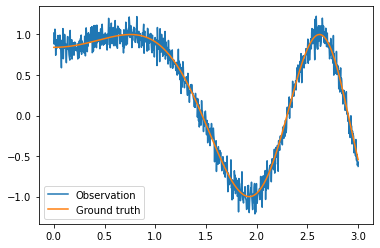

In [3]:
x = np.linspace(0.0, 3.0, N_samples, dtype=np.float32)
y = np.expand_dims(np.sin(1.0+x*x) + noise_sig*np.random.randn(N_samples).astype(np.float32), axis=-1)
y_true = np.sin(1.0+x*x)

plt.plot(x, y)
plt.plot(x, y_true)
plt.legend(["Observation", "Ground truth"])
plt.show()

With the input-output pairs created, your first task is now to partition the data in the training, validation and test sets. Keep in mind that we have created the data in a structured way, i.e. the input-output pairs are ordered. This means you need to shuffle the data before partitioning it.

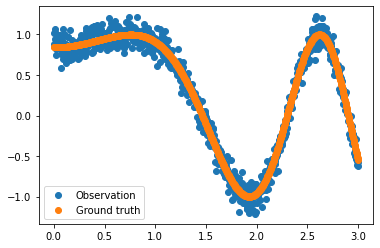

In [4]:
index = np.arange(N_samples)
np.random.shuffle(index)

X_shuffle = x[index]
y_true_shuffle = y_true[index]
y_shuffle = y[index]

plt.scatter(X_shuffle, y_shuffle)
plt.scatter(X_shuffle, y_true_shuffle)
plt.legend(["Observation", "Ground truth"])
plt.show()

In [5]:
""" Shuffle and partition the data set accordingly. you can use the predefined constants "N_train_samples", "N_validation_samples" and "N_test_samples". Use the variable names that are already in the below code 
to store the final shuffled and partitioned data. Hint: Shuffle the data and the labels in such a way that the pairing between an image and it's label is preserved."""
# Shuffle the data
index = np.arange(N_samples)
np.random.shuffle(index)

X_shuffle = x[index]
y_true_shuffle = y_true[index]
y_shuffle = y[index]

# Partition the data
x_train = X_shuffle[0:N_train_samples]
y_train = y_shuffle[0:N_train_samples]
x_validation = X_shuffle[N_train_samples:N_train_samples+N_validation_samples]
y_validation = y_shuffle[N_train_samples:N_train_samples+N_validation_samples]
x_test = X_shuffle[N_train_samples+N_validation_samples:N_samples]
y_test = y_shuffle[N_train_samples+N_validation_samples:N_samples]

print(x_train[:8])
print(y_train[:8])

[0.3379224 2.4142678 0.4430538 0.9461827 1.9637046 1.7571965 2.7033792
 2.4405508]
[[ 0.8572369 ]
 [ 0.41922757]
 [ 0.9920987 ]
 [ 0.9620166 ]
 [-1.0785834 ]
 [-1.0400305 ]
 [ 0.85989124]
 [ 0.6521057 ]]


In order to feed the data to our model, we will use the Dataset class provided by Tensorflow. This class is simple to use and provides all the functionality we need for shuffling, batching and feeding the data to our model. It is also tightly integrated into the Tensorflow framework, which makes it very performant. Performance is not an aspect we need to worry about in this exercise, but it is important in more demanding applications.

In this exercise we instantiate a separate Dataset object for the training, validation and test data sets, where we shuffle and repeat just the training data set. Shuffling the validation and test data sets is not necessary, since we only evaluate the loss on those data sets and do not perform SGD on it. Please fill in the missing part of the code.

In [6]:
""" Create three tensorflow Dataset objects that can be used to feed the training test and validation data to a neural network. Hint: For the training data set use shuffling, batching with the size according to
the predefined constant "batch_size" and repeat the data set indefinetly. For the validation and test data sets no shuffling or batching is needed."""

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(N_train_samples).batch(batch_size).repeat()
validation_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In this exercise we will create a a simple neural network with two hidden layers containing $10$ neurons. For creating a model and keeping track of its weights a class called MyModel is used. When initializing an instance of this class the necessary variables are created and stored in a list called "trainable_variables". This makes it easy to get all trainable variables of the model. We also override the \__call__ method of this class in order to implement the forward pass of the neural network. This method should accept the inputs to the neural network and should return the result of the forward pass as an output. Please fill in the missing part of the code and select suitable activation functions for the different layers.

In [7]:
a=tf.zeros(1,dtype=tf.dtypes.float32)
print(a)

tf.Tensor([0.], shape=(1,), dtype=float32)


In [8]:
""" Implement a neural network with two hidden dense layers containing 10 neurons each. As an activation function use the tangens hyperbolicus (tf.nn.tanh()). Since we are not using Keras, we need to create and 
manage all the variables that we need ourselves. The varaibles are created in the constructor of our model class. Since we want to be able to just call the class with some inputs in order to make a prediction, 
we implement a __call__ method which computes the forward pass and returns the output of the network."""

class MyModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.normal([1,10],dtype=tf.dtypes.float32))
        self.b0 = tf.Variable(tf.zeros(shape=(1,10),dtype=tf.dtypes.float32))
        self.W1 = tf.Variable(tf.random.normal([10,10],dtype=tf.dtypes.float32))
        self.b1 = tf.Variable(tf.zeros(shape=(1,10),dtype=tf.dtypes.float32))
        self.W2 = tf.Variable(tf.random.normal([10,1],dtype=tf.dtypes.float32))
        self.b2 = tf.Variable(tf.zeros(1,dtype=tf.dtypes.float32))
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.matmul(output,self.W0)+self.b0)
        output = tf.nn.tanh(tf.matmul(output,self.W1)+self.b1)
        output = tf.nn.tanh(tf.matmul(output,self.W2)+self.b2)
        return output

Now after the model class is defined we can instantiate a MyModel object by running

In [9]:
mdl = MyModel()

We can now use the model to make predictions by calling it. In the following we predict on the inputs an plot the result.

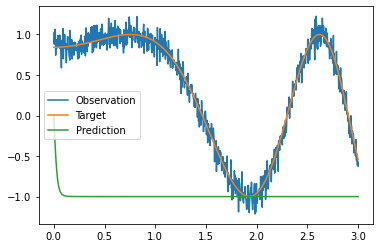

In [10]:
""" We want to plot a prediction on the complete data set with a model before training. For this make a prediction on the variable "x". """

y_pred = mdl(x)
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Since we have initialized the variables of the neural network randomly, it's prediction is also random. In order to fit the model we need to minimize the expected mean squared error over all input-ouput pairs in our training data set. For this we need to create a function, that performs a training step when provided with the model, an optimizer and a batch of input-ouput pairs.

In [11]:
""" For training we need to implement a function that executes one training step. Fill in the missing code pieces for this function."""

def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # Compute a prediction with "model" on the input "x"
        y_pred = model(x)
        # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y"
        loss_val = tf.reduce_mean(tf.square(y-y_pred))
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

This function uses the GradientTape to record the operations for which gradients have to be calculated. In our case this is the forward pass through our model and the computation of the loss function. After these operations are recoded we can get their gradients and apply these through the use of an optimizer. Finally we return the loss value in order to print it.

With the training step function defined we now need to choose a suitable optimizer. Tensorflow offers a wide variety of optimizers but in this exercise we will use the RMSprop optimizer.

In [12]:
opt = tf.optimizers.RMSprop(learning_rate)

We now have everything we need to start training the model. For this we repeatedly sample a batch of input-output pairs from our training data set and use the train_step function to minimize the loss function over this batch. We repeat this until we have iterated over the complete training data set once. After this we compute the loss on the validation data set, print it and repeat with another epoch until we have reached $N\_epochs$ epochs.

In [13]:
""" We can now use the train_step function to perform the training. Fill in the missing code parts."""

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_ds:
    # Perform a training step with the model "mdl" and the optimizer "opt" on the inputs "x_t" and the corresponding targets "y_t"
    train_loss += train_step(mdl, opt, x_t, y_t)
    train_iters += 1
    
    if (train_iters==(N_samples/batch_size)):
        for x_v, y_v in validation_ds:
            # Compute a prediction with "mdl" on the input "x_v"
            y_pred = mdl(x_v)
            # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_v"
            validation_loss = tf.reduce_mean(tf.square(y-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 0.4284 Validation loss: 0.93031
Epoch: 1 Train loss: 0.19394 Validation loss: 0.85996
Epoch: 2 Train loss: 0.13488 Validation loss: 0.90924
Epoch: 3 Train loss: 0.09808 Validation loss: 0.90832
Epoch: 4 Train loss: 0.092038 Validation loss: 0.87339
Epoch: 5 Train loss: 0.078432 Validation loss: 0.92066
Epoch: 6 Train loss: 0.070957 Validation loss: 0.90852
Epoch: 7 Train loss: 0.068309 Validation loss: 0.91815
Epoch: 8 Train loss: 0.069945 Validation loss: 0.91489
Epoch: 9 Train loss: 0.071399 Validation loss: 0.91982
Epoch: 10 Train loss: 0.055126 Validation loss: 0.91705
Epoch: 11 Train loss: 0.065237 Validation loss: 0.91583
Epoch: 12 Train loss: 0.059397 Validation loss: 0.91457
Epoch: 13 Train loss: 0.064855 Validation loss: 0.90817
Epoch: 14 Train loss: 0.058547 Validation loss: 0.91378
Epoch: 15 Train loss: 0.055249 Validation loss: 0.91735
Epoch: 16 Train loss: 0.059634 Validation loss: 0.92044
Epoch: 17 Train loss: 0.050226 Validation loss: 0.91707
Epoch: 

Epoch: 147 Train loss: 0.018062 Validation loss: 0.90193
Epoch: 148 Train loss: 0.019739 Validation loss: 0.8966
Epoch: 149 Train loss: 0.019772 Validation loss: 0.90018


After completion of the training process we use the test data set to test the models generalization to unseen data.

In [14]:
for x_t, y_t in test_ds:
    y_pred = mdl(x_t)
    test_loss = tf.reduce_mean(tf.square(y_t-y_pred))
print("Test loss: {:.5}".format(test_loss))

Test loss: 0.0038355


After we have verified that our model achieves a similar loss on the test as on the validation and training data set, we can conclude that our model is not overfitting or underfitting and generalizes to unseen data. We can now predict on the inputs again and plot the results.

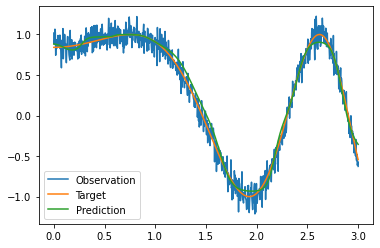

In [15]:
""" Now we want to plot the prediction after training. Predict on the variable "x" again. """

y_pred = mdl(x)
plt.plot(x, y)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

Now our model has learned to approximate the function mapping from the input to the output. The capability of neural networks to learn from input-ouput pairs alone and approximate an arbitrary function, see universal approximation theorem, can be very useful if the mapping between the input and output is too complex to be captured with model based approaches. But learning from input-ouput pairs alone implies that the model will only be able to make accurate predictions over input ranges it has seen during training. In order to demonstrate this we will predict on an interval that exeeds the $\left[0,3\right]$ interval the model was trained on, i.e. we will predict on the interval $\left[-2,5\right]$.

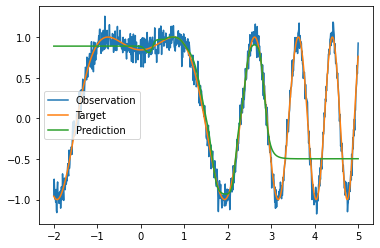

In [16]:
x_generalize = np.linspace(-2.0, 5.0, N_samples, dtype=np.float32)
y_generalize = np.sin(1.0+x_generalize*x_generalize) + noise_sig*np.random.randn(N_samples).astype(np.float32)
y_truey_generalize = np.sin(1.0+x_generalize*x_generalize)
y_pred = mdl(x_generalize)
plt.plot(x_generalize, y_generalize)
plt.plot(x_generalize, y_truey_generalize)
plt.plot(x_generalize, y_pred.numpy())
plt.legend(["Observation", "Target", "Prediction"])
plt.show()

As expected, the model is able to make farely accurate predictions on the interval it was trained on but makes unreliable predictions outside this interval.

### Regularization
With the theoretical background on regularization we can now implement it and observe it's effects on the regression problem covered in this exercise. For this we will define a model with a high capacity and train it for a extended time to provoke overfitting. For this, we will increase the number of hidden neurons in both hidden layers to $100$ and $50$.

In [17]:
""" Implement a bigger model with again two hidden layers contatining 100 and 50 neurons. As an activation use the tangens hyperbolicus function where it is appropiate. """

class MyBigModel(object):
    def __init__(self):
        # Create model variables
        self.W0 = tf.Variable(tf.random.normal([1,100],dtype=tf.dtypes.float32))
        self.b0 = tf.Variable(tf.zeros(shape=(1,100),dtype=tf.dtypes.float32))
        self.W1 = tf.Variable(tf.random.normal([100,50],dtype=tf.dtypes.float32))
        self.b1 = tf.Variable(tf.zeros(shape=(1,50),dtype=tf.dtypes.float32))
        self.W2 = tf.Variable(tf.random.normal([50,1],dtype=tf.dtypes.float32))
        self.b2 = tf.Variable(tf.zeros(1,dtype=tf.dtypes.float32))
        self.trainable_variables = [self.W0, self.b0, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, inputs):
        # Compute forward pass
        output = tf.reshape(inputs, [-1, 1])
        output = tf.nn.tanh(tf.matmul(output,self.W0)+self.b0)
        output = tf.nn.tanh(tf.matmul(output,self.W1)+self.b1)
        output = tf.nn.tanh(tf.matmul(output,self.W2)+self.b2) 
        return output

After creating one instance of this class we can again train it on our data set. We will also create a new optimizer for training this bigger model, since some optimizers adapt the learning rates for individual parameters during a training process and we do not want to train our bigger model with learning rates adopted from an earlier training run.

In [18]:
big_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

Now we are ready to train this bigger model using the same training step and training loop. In order to provoke overfitting we also reduce the number of samples in the training data set a lot, increase the batch size and train for a more epochs.

In [19]:
""" Implement the training for the bigger model similar to the training of the small model before. """

N_train_samples_overfit = 30
N_epochs = 1000
batch_size = 30

sel_idx = np.arange(0, N_train_samples)
sel_idx = np.random.choice(sel_idx, N_train_samples_overfit)
x_train_overfit = x_train[sel_idx]
y_train_overfit = y_train[sel_idx]

train_overfit_ds = tf.data.Dataset.from_tensor_slices((x_train_overfit, y_train_overfit)).shuffle(N_train_samples_overfit).batch(batch_size).repeat()

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    # Perform a training step with the model "big_mdl" and the optimizer "big_opt" on the inputs "x_t" and the corresponding targets "y_t"
    train_loss += train_step(big_mdl, big_opt, x_t, y_t)
    train_iters += 1
    if (train_iters==(N_train_samples_overfit/batch_size)):
        for x_v, y_v in validation_ds:
            y_pred = big_mdl(x_v)
            validation_loss = tf.reduce_mean(tf.square(y_t-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 0.56417 Validation loss: 1.1151
Epoch: 1 Train loss: 0.67766 Validation loss: 0.83944
Epoch: 2 Train loss: 0.62662 Validation loss: 1.1021
Epoch: 3 Train loss: 0.2957 Validation loss: 1.0904
Epoch: 4 Train loss: 0.2548 Validation loss: 1.071
Epoch: 5 Train loss: 0.23344 Validation loss: 1.0724
Epoch: 6 Train loss: 0.22922 Validation loss: 1.0239
Epoch: 7 Train loss: 0.28957 Validation loss: 1.1155
Epoch: 8 Train loss: 0.65019 Validation loss: 0.84606
Epoch: 9 Train loss: 0.6587 Validation loss: 1.0935
Epoch: 10 Train loss: 0.32913 Validation loss: 1.1231
Epoch: 11 Train loss: 0.30523 Validation loss: 1.0487
Epoch: 12 Train loss: 0.41545 Validation loss: 1.1233
Epoch: 13 Train loss: 0.28676 Validation loss: 1.0545
Epoch: 14 Train loss: 0.41827 Validation loss: 1.1236
Epoch: 15 Train loss: 0.24753 Validation loss: 1.0892
Epoch: 16 Train loss: 0.29255 Validation loss: 1.1243
Epoch: 17 Train loss: 0.33025 Validation loss: 1.0308
Epoch: 18 Train loss: 0.51618 Validation

Epoch: 154 Train loss: 0.13919 Validation loss: 1.1293
Epoch: 155 Train loss: 0.12915 Validation loss: 1.1254
Epoch: 156 Train loss: 0.1388 Validation loss: 1.1294
Epoch: 157 Train loss: 0.12878 Validation loss: 1.1255
Epoch: 158 Train loss: 0.13847 Validation loss: 1.1294
Epoch: 159 Train loss: 0.12843 Validation loss: 1.1255
Epoch: 160 Train loss: 0.13818 Validation loss: 1.1294
Epoch: 161 Train loss: 0.12812 Validation loss: 1.1256
Epoch: 162 Train loss: 0.13795 Validation loss: 1.1294
Epoch: 163 Train loss: 0.12783 Validation loss: 1.1256
Epoch: 164 Train loss: 0.13776 Validation loss: 1.1295
Epoch: 165 Train loss: 0.12757 Validation loss: 1.1257
Epoch: 166 Train loss: 0.13764 Validation loss: 1.1295
Epoch: 167 Train loss: 0.12734 Validation loss: 1.1257
Epoch: 168 Train loss: 0.13757 Validation loss: 1.1295
Epoch: 169 Train loss: 0.12713 Validation loss: 1.1258
Epoch: 170 Train loss: 0.13756 Validation loss: 1.1296
Epoch: 171 Train loss: 0.12696 Validation loss: 1.1258
Epoch: 172 

Epoch: 307 Train loss: 0.12313 Validation loss: 1.125
Epoch: 308 Train loss: 0.1298 Validation loss: 1.1292
Epoch: 309 Train loss: 0.12278 Validation loss: 1.1249
Epoch: 310 Train loss: 0.1291 Validation loss: 1.1291
Epoch: 311 Train loss: 0.12239 Validation loss: 1.1248
Epoch: 312 Train loss: 0.12836 Validation loss: 1.1291
Epoch: 313 Train loss: 0.12195 Validation loss: 1.1246
Epoch: 314 Train loss: 0.12758 Validation loss: 1.129
Epoch: 315 Train loss: 0.12146 Validation loss: 1.1245
Epoch: 316 Train loss: 0.12676 Validation loss: 1.1289
Epoch: 317 Train loss: 0.12093 Validation loss: 1.1244
Epoch: 318 Train loss: 0.12589 Validation loss: 1.1288
Epoch: 319 Train loss: 0.12033 Validation loss: 1.1242
Epoch: 320 Train loss: 0.12497 Validation loss: 1.1287
Epoch: 321 Train loss: 0.11968 Validation loss: 1.1241
Epoch: 322 Train loss: 0.12401 Validation loss: 1.1287
Epoch: 323 Train loss: 0.11896 Validation loss: 1.1239
Epoch: 324 Train loss: 0.12299 Validation loss: 1.1286
Epoch: 325 Tra

Epoch: 456 Train loss: 0.041011 Validation loss: 1.1109
Epoch: 457 Train loss: 0.04068 Validation loss: 1.1046
Epoch: 458 Train loss: 0.040509 Validation loss: 1.1105
Epoch: 459 Train loss: 0.040194 Validation loss: 1.1041
Epoch: 460 Train loss: 0.040021 Validation loss: 1.11
Epoch: 461 Train loss: 0.039722 Validation loss: 1.1037
Epoch: 462 Train loss: 0.039547 Validation loss: 1.1096
Epoch: 463 Train loss: 0.039264 Validation loss: 1.1032
Epoch: 464 Train loss: 0.039087 Validation loss: 1.1091
Epoch: 465 Train loss: 0.038817 Validation loss: 1.1027
Epoch: 466 Train loss: 0.038639 Validation loss: 1.1086
Epoch: 467 Train loss: 0.038384 Validation loss: 1.1023
Epoch: 468 Train loss: 0.038205 Validation loss: 1.1081
Epoch: 469 Train loss: 0.037961 Validation loss: 1.1018
Epoch: 470 Train loss: 0.037782 Validation loss: 1.1077
Epoch: 471 Train loss: 0.03755 Validation loss: 1.1013
Epoch: 472 Train loss: 0.037371 Validation loss: 1.1072
Epoch: 473 Train loss: 0.03715 Validation loss: 1.10

Epoch: 605 Train loss: 0.022285 Validation loss: 1.0403
Epoch: 606 Train loss: 0.02222 Validation loss: 1.0485
Epoch: 607 Train loss: 0.022191 Validation loss: 1.0401
Epoch: 608 Train loss: 0.022127 Validation loss: 1.0483
Epoch: 609 Train loss: 0.022099 Validation loss: 1.0399
Epoch: 610 Train loss: 0.022035 Validation loss: 1.0481
Epoch: 611 Train loss: 0.022007 Validation loss: 1.0398
Epoch: 612 Train loss: 0.021944 Validation loss: 1.048
Epoch: 613 Train loss: 0.021916 Validation loss: 1.0397
Epoch: 614 Train loss: 0.021853 Validation loss: 1.0479
Epoch: 615 Train loss: 0.021825 Validation loss: 1.0397
Epoch: 616 Train loss: 0.021763 Validation loss: 1.0478
Epoch: 617 Train loss: 0.021735 Validation loss: 1.0396
Epoch: 618 Train loss: 0.021673 Validation loss: 1.0477
Epoch: 619 Train loss: 0.021644 Validation loss: 1.0396
Epoch: 620 Train loss: 0.021582 Validation loss: 1.0476
Epoch: 621 Train loss: 0.021553 Validation loss: 1.0397
Epoch: 622 Train loss: 0.021492 Validation loss: 1

Epoch: 753 Train loss: 0.017141 Validation loss: 1.0488
Epoch: 754 Train loss: 0.01712 Validation loss: 1.0519
Epoch: 755 Train loss: 0.0171 Validation loss: 1.049
Epoch: 756 Train loss: 0.017079 Validation loss: 1.052
Epoch: 757 Train loss: 0.01706 Validation loss: 1.0491
Epoch: 758 Train loss: 0.017039 Validation loss: 1.0521
Epoch: 759 Train loss: 0.01702 Validation loss: 1.0492
Epoch: 760 Train loss: 0.017 Validation loss: 1.0522
Epoch: 761 Train loss: 0.016981 Validation loss: 1.0493
Epoch: 762 Train loss: 0.016961 Validation loss: 1.0523
Epoch: 763 Train loss: 0.016943 Validation loss: 1.0494
Epoch: 764 Train loss: 0.016923 Validation loss: 1.0524
Epoch: 765 Train loss: 0.016905 Validation loss: 1.0495
Epoch: 766 Train loss: 0.016885 Validation loss: 1.0525
Epoch: 767 Train loss: 0.016867 Validation loss: 1.0496
Epoch: 768 Train loss: 0.016848 Validation loss: 1.0526
Epoch: 769 Train loss: 0.01683 Validation loss: 1.0497
Epoch: 770 Train loss: 0.016811 Validation loss: 1.0527
Epo

Epoch: 901 Train loss: 0.018716 Validation loss: 1.0513
Epoch: 902 Train loss: 0.018609 Validation loss: 1.0637
Epoch: 903 Train loss: 0.018649 Validation loss: 1.0514
Epoch: 904 Train loss: 0.018537 Validation loss: 1.0637
Epoch: 905 Train loss: 0.01857 Validation loss: 1.0515
Epoch: 906 Train loss: 0.018455 Validation loss: 1.0637
Epoch: 907 Train loss: 0.018481 Validation loss: 1.0516
Epoch: 908 Train loss: 0.018363 Validation loss: 1.0637
Epoch: 909 Train loss: 0.018383 Validation loss: 1.0517
Epoch: 910 Train loss: 0.018263 Validation loss: 1.0636
Epoch: 911 Train loss: 0.018278 Validation loss: 1.0518
Epoch: 912 Train loss: 0.018159 Validation loss: 1.0636
Epoch: 913 Train loss: 0.018169 Validation loss: 1.0519
Epoch: 914 Train loss: 0.018049 Validation loss: 1.0636
Epoch: 915 Train loss: 0.018056 Validation loss: 1.052
Epoch: 916 Train loss: 0.017938 Validation loss: 1.0636
Epoch: 917 Train loss: 0.01794 Validation loss: 1.0521
Epoch: 918 Train loss: 0.017824 Validation loss: 1.

Predicting with this model shows overfitting. For recognizing overfitting a comparison of the validation and training loss is very useful. If the training loss decreases during training while the validation loss consistently increases, the model you are training is probably overfitting. Plotting the models prediction and the target also shows that there is a significant discrepancy between the target and the prediction of the model.

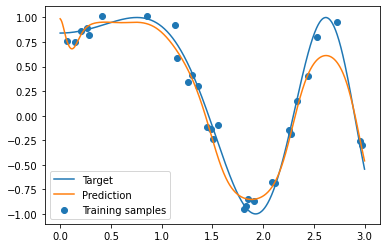

In [20]:
y_pred = big_mdl(x)
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.legend(["Target", "Prediction", "Training samples"])
plt.show()

In order to implement a regularization we need to modify the loss function. Since the loss function in this exercise is computed during the training step, we define a new training step with a regularization.

In [21]:
""" In order to avoid overfitting we implement a training step that also includes a regularization on the weights of our big model. For this we use the Frobenius/squared l2-norm of each weight matrix/vector. 
Hint: Use the tf.reduce_sum() function on a list of individual regularization terms for each matrix/vector of the network."""

def regularized_train_step(model, optimizer, x, y, lmbd):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x)
        loss_val =tf.reduce_mean(tf.square(y-y_pred))
        # Compute the regularization based on the list "model.trainable_variables"
        regul_val = sum([tf.reduce_sum(tf.square(model.trainable_variables[i])) for i in range(len(model.trainable_variables)) if i%2==0])
        # Add the loss with a the regularization term weighted by "lmbd"
        total_loss = loss_val + lmbd*regul_val
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

We can now set the strength of the regularization and retrain the big model with a regularization. We create another instance of the big model in order to compare the big model with and without regularization.

In [22]:
""" Implement the training for the bigger model with the regularized_train_step function. Note: We are plotting the MSE loss without the regularization in order to compare it with the unregularized model. """

lmbd = 0.005

big_reg_mdl = MyBigModel()
big_opt = tf.optimizers.SGD(learning_rate)

epoch = 0
train_iters = 0
train_loss = 0.0
for x_t, y_t in train_overfit_ds:
    # Perform a regularized training step with the model "big_mdl" and the optimizer "big_opt" on the inputs "x_t" and the corresponding targets "y_t" with the regularization parameter being "lmbd"
    train_loss +=regularized_train_step(big_reg_mdl, big_opt, x_t, y_t, lmbd)
    train_iters += 1
    if (train_iters==(N_train_samples_overfit/batch_size)):
        for x_v, y_v in validation_ds:
            # Compute a prediction with "big_mdl" on the input "x_v"
            y_pred = big_reg_mdl(x_v)
            # Compute the Mean Squared Error (MSE) for the prediction "y_pred" and the targets "y_v"
            validation_loss = tf.reduce_mean(tf.square(y_v-y_pred))
        print("Epoch: {} Train loss: {:.5} Validation loss: {:.5}".format(epoch, train_loss/train_iters, validation_loss))
        train_iters = 0
        train_loss = 0.0
        train_reg = 0.0
        epoch += 1
    if (epoch == N_epochs):
        break

Epoch: 0 Train loss: 1.1223 Validation loss: 0.017314
Epoch: 1 Train loss: 1.1183 Validation loss: 0.017307
Epoch: 2 Train loss: 1.1113 Validation loss: 0.017297
Epoch: 3 Train loss: 1.0972 Validation loss: 0.017279
Epoch: 4 Train loss: 1.0625 Validation loss: 0.017236
Epoch: 5 Train loss: 0.95264 Validation loss: 0.017094
Epoch: 6 Train loss: 0.66305 Validation loss: 0.016519
Epoch: 7 Train loss: 0.37309 Validation loss: 0.01514
Epoch: 8 Train loss: 0.26226 Validation loss: 0.014936
Epoch: 9 Train loss: 0.21567 Validation loss: 0.014154
Epoch: 10 Train loss: 0.1909 Validation loss: 0.01416
Epoch: 11 Train loss: 0.18038 Validation loss: 0.014206
Epoch: 12 Train loss: 0.17246 Validation loss: 0.014635
Epoch: 13 Train loss: 0.16833 Validation loss: 0.014326
Epoch: 14 Train loss: 0.17763 Validation loss: 0.015293
Epoch: 15 Train loss: 0.21586 Validation loss: 0.01378
Epoch: 16 Train loss: 0.31137 Validation loss: 0.015891
Epoch: 17 Train loss: 0.18098 Validation loss: 0.014585
Epoch: 18 T

Epoch: 146 Train loss: 0.13681 Validation loss: 0.0094485
Epoch: 147 Train loss: 0.13251 Validation loss: 0.0072574
Epoch: 148 Train loss: 0.13666 Validation loss: 0.009365
Epoch: 149 Train loss: 0.13237 Validation loss: 0.0071637
Epoch: 150 Train loss: 0.13651 Validation loss: 0.0092812
Epoch: 151 Train loss: 0.13223 Validation loss: 0.0070694
Epoch: 152 Train loss: 0.13636 Validation loss: 0.0091966
Epoch: 153 Train loss: 0.13209 Validation loss: 0.0069746
Epoch: 154 Train loss: 0.13621 Validation loss: 0.0091116
Epoch: 155 Train loss: 0.13195 Validation loss: 0.0068793
Epoch: 156 Train loss: 0.13607 Validation loss: 0.0090259
Epoch: 157 Train loss: 0.13182 Validation loss: 0.0067835
Epoch: 158 Train loss: 0.13593 Validation loss: 0.0089397
Epoch: 159 Train loss: 0.13168 Validation loss: 0.006687
Epoch: 160 Train loss: 0.13579 Validation loss: 0.0088528
Epoch: 161 Train loss: 0.13155 Validation loss: 0.0065901
Epoch: 162 Train loss: 0.13565 Validation loss: 0.0087655
Epoch: 163 Train

Epoch: 290 Train loss: 0.12969 Validation loss: 0.0023094
Epoch: 291 Train loss: 0.12519 Validation loss: 0.00037734
Epoch: 292 Train loss: 0.12962 Validation loss: 0.0022107
Epoch: 293 Train loss: 0.12511 Validation loss: 0.00032435
Epoch: 294 Train loss: 0.12955 Validation loss: 0.0021131
Epoch: 295 Train loss: 0.12503 Validation loss: 0.00027479
Epoch: 296 Train loss: 0.12948 Validation loss: 0.0020166
Epoch: 297 Train loss: 0.12495 Validation loss: 0.00022887
Epoch: 298 Train loss: 0.12941 Validation loss: 0.0019213
Epoch: 299 Train loss: 0.12487 Validation loss: 0.00018668
Epoch: 300 Train loss: 0.12934 Validation loss: 0.0018273
Epoch: 301 Train loss: 0.1248 Validation loss: 0.0001484
Epoch: 302 Train loss: 0.12927 Validation loss: 0.0017348
Epoch: 303 Train loss: 0.12472 Validation loss: 0.00011417
Epoch: 304 Train loss: 0.1292 Validation loss: 0.0016437
Epoch: 305 Train loss: 0.12464 Validation loss: 8.4135e-05
Epoch: 306 Train loss: 0.12913 Validation loss: 0.0015542
Epoch: 30

Epoch: 434 Train loss: 0.12365 Validation loss: 0.00085942
Epoch: 435 Train loss: 0.11892 Validation loss: 0.0071759
Epoch: 436 Train loss: 0.12355 Validation loss: 0.00088395
Epoch: 437 Train loss: 0.11883 Validation loss: 0.0072645
Epoch: 438 Train loss: 0.12345 Validation loss: 0.0009069
Epoch: 439 Train loss: 0.11873 Validation loss: 0.007346
Epoch: 440 Train loss: 0.12335 Validation loss: 0.00092813
Epoch: 441 Train loss: 0.11863 Validation loss: 0.0074207
Epoch: 442 Train loss: 0.12324 Validation loss: 0.00094768
Epoch: 443 Train loss: 0.11854 Validation loss: 0.0074883
Epoch: 444 Train loss: 0.12314 Validation loss: 0.00096546
Epoch: 445 Train loss: 0.11844 Validation loss: 0.007549
Epoch: 446 Train loss: 0.12304 Validation loss: 0.00098149
Epoch: 447 Train loss: 0.11835 Validation loss: 0.0076025
Epoch: 448 Train loss: 0.12294 Validation loss: 0.00099575
Epoch: 449 Train loss: 0.11825 Validation loss: 0.0076493
Epoch: 450 Train loss: 0.12284 Validation loss: 0.0010083
Epoch: 45

Epoch: 577 Train loss: 0.11306 Validation loss: 0.0038681
Epoch: 578 Train loss: 0.11746 Validation loss: 0.00015453
Epoch: 579 Train loss: 0.11299 Validation loss: 0.003794
Epoch: 580 Train loss: 0.11739 Validation loss: 0.00014333
Epoch: 581 Train loss: 0.11292 Validation loss: 0.0037206
Epoch: 582 Train loss: 0.11732 Validation loss: 0.00013257
Epoch: 583 Train loss: 0.11285 Validation loss: 0.0036481
Epoch: 584 Train loss: 0.11725 Validation loss: 0.00012224
Epoch: 585 Train loss: 0.11278 Validation loss: 0.0035766
Epoch: 586 Train loss: 0.11718 Validation loss: 0.00011237
Epoch: 587 Train loss: 0.11271 Validation loss: 0.003506
Epoch: 588 Train loss: 0.11711 Validation loss: 0.00010293
Epoch: 589 Train loss: 0.11264 Validation loss: 0.0034361
Epoch: 590 Train loss: 0.11705 Validation loss: 9.3935e-05
Epoch: 591 Train loss: 0.11257 Validation loss: 0.0033673
Epoch: 592 Train loss: 0.11698 Validation loss: 8.5372e-05
Epoch: 593 Train loss: 0.1125 Validation loss: 0.0032993
Epoch: 59

Epoch: 719 Train loss: 0.10828 Validation loss: 0.00066344
Epoch: 720 Train loss: 0.11269 Validation loss: 0.0002363
Epoch: 721 Train loss: 0.10822 Validation loss: 0.00064232
Epoch: 722 Train loss: 0.11262 Validation loss: 0.00024598
Epoch: 723 Train loss: 0.10815 Validation loss: 0.00062169
Epoch: 724 Train loss: 0.11256 Validation loss: 0.00025582
Epoch: 725 Train loss: 0.10808 Validation loss: 0.0006015
Epoch: 726 Train loss: 0.11249 Validation loss: 0.00026575
Epoch: 727 Train loss: 0.10802 Validation loss: 0.00058179
Epoch: 728 Train loss: 0.11242 Validation loss: 0.00027583
Epoch: 729 Train loss: 0.10795 Validation loss: 0.00056253
Epoch: 730 Train loss: 0.11236 Validation loss: 0.00028602
Epoch: 731 Train loss: 0.10789 Validation loss: 0.00054373
Epoch: 732 Train loss: 0.11229 Validation loss: 0.00029632
Epoch: 733 Train loss: 0.10782 Validation loss: 0.0005253
Epoch: 734 Train loss: 0.11222 Validation loss: 0.00030673
Epoch: 735 Train loss: 0.10775 Validation loss: 0.00050733


Epoch: 859 Train loss: 0.10356 Validation loss: 4.9651e-06
Epoch: 860 Train loss: 0.10789 Validation loss: 0.00108
Epoch: 861 Train loss: 0.1035 Validation loss: 3.8336e-06
Epoch: 862 Train loss: 0.10782 Validation loss: 0.0010929
Epoch: 863 Train loss: 0.10343 Validation loss: 2.8594e-06
Epoch: 864 Train loss: 0.10775 Validation loss: 0.0011058
Epoch: 865 Train loss: 0.10336 Validation loss: 2.0297e-06
Epoch: 866 Train loss: 0.10767 Validation loss: 0.0011187
Epoch: 867 Train loss: 0.10329 Validation loss: 1.3443e-06
Epoch: 868 Train loss: 0.1076 Validation loss: 0.0011316
Epoch: 869 Train loss: 0.10322 Validation loss: 8.0277e-07
Epoch: 870 Train loss: 0.10753 Validation loss: 0.0011444
Epoch: 871 Train loss: 0.10315 Validation loss: 4.0197e-07
Epoch: 872 Train loss: 0.10746 Validation loss: 0.0011573
Epoch: 873 Train loss: 0.10308 Validation loss: 1.3998e-07
Epoch: 874 Train loss: 0.10739 Validation loss: 0.0011701
Epoch: 875 Train loss: 0.10301 Validation loss: 1.3247e-08
Epoch: 87

During the training of the regularized model we can already notice, that, although there is still a difference between training and validation loss, the validation loss decreases as the training loss dreases. The effect of the regularization becomes even more evident if we plot the predictions of the regularized model and the overfitting model.

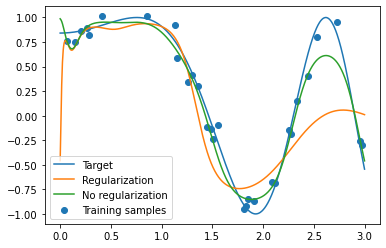

In [23]:
""" We now want to plot the prediction of the regularized and unregularized big model. """

y_pred = big_reg_mdl(x)
y_pred_overfit = big_mdl(x)
plt.scatter(x_train_overfit, y_train_overfit)
plt.plot(x, y_true)
plt.plot(x, y_pred.numpy())
plt.plot(x, y_pred_overfit.numpy())
plt.legend(["Target", "Regularization", "No regularization", "Training samples"])
plt.show()

The model with regularization seems to follow the overall trend of the data, while the model without any regularization very precisely fits the training samples. This is espacilly evident in the interval $\left[0,0.5\right]$, where the prediction of the unregularized model shows an oscillating behavior. Such oscillations are however not present in the ground truth and therefore undesirable. The regularized model on the other hand is not as flexible as the unregularized model and therefore does not fit the target function well in the interval $\left[2.25, 3.0\right]$.

## Conclusion
In this exercise we revisited the mathematical background for a simple regression task and covered it's practical implementation in Tensorflow 2. We also explored the phenomenon of overfitting and derived different regularizations from a probabilistic perspective. This exercise covers a very simple task with a very basic neural architecture and is intended as a primer for the second part of the regression exercise, which is dealing with a bigger and more realistic problem. In this second part we will consider the problem of estimating the age of a person from a potrait picture.